In [2]:
!nvidia-smi

Sat May  7 16:23:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('cnontent/')

Drive already mounted at cnontent/; to attempt to forcibly remount, call drive.mount("cnontent/", force_remount=True).


In [4]:
!pip install -q wandb

In [5]:
!wandb login

wandb: Currently logged in as: chanin-eom. Use `wandb login --relogin` to force relogin


In [6]:
import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
import os
from wandb.keras import WandbCallback
import random
%matplotlib inline

In [7]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [8]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [9]:
def print_lable_with_value(): # value 갑과 matching되는 label 값 출력
  global label_value_list
  label_value_list = []
  for i in range(62):
    if i <=9:
      print(f"label : {i}, value : {i}")
      label_value_list.append(f'{i}')
    elif 10<=i<=35:
      print(f"label : {i}, value : {chr(i+55)}")
      label_value_list.append(f'{chr(i+55)}')
    else:
      print(f"label : {i}, value : {chr(i+61)}")
      label_value_list.append(f'{chr(i+61)}')

In [10]:
def show_data_scheme(data, label, row = 4, col = 5, i = 1): # data 어떻게 생겼는지 plot
  plt.figure(figsize = (11, 8))
  for r in range(row):
    for c in range(col):
      plt.subplot(row, col, i)
      plt.imshow(data[i,...,0], 'gray')
      plt.axis('off')
      plt.title(f'{label_value_list[label[i]]}')
      i+=1
  plt.show()

In [11]:
def balanced_data(data, n_train=1000, val_rate = 0.2):
  i, start=0,0
  d_train = l_train = d_val = l_val= None
  n_data_per_class = n_train
  n_val_per_class = int(n_data_per_class*val_rate)


  for idx, class_end in enumerate(border):
    if i ==0:
      val_end = n_data_per_class+n_val_per_class

      d_train = data[:n_data_per_class].copy()
      l_train = train_label[:n_data_per_class].copy()

      d_val = data[n_data_per_class:val_end].copy()
      l_val = train_label[n_data_per_class:val_end].copy()

      i+=1
    else:
      train_end = start+n_data_per_class
      val_end = train_end+n_val_per_class

      now_d_data = data[start:train_end].copy()
      now_l_train = train_label[start:train_end].copy()
      d_train = np.concatenate((d_train, now_d_data))
      l_train = np.concatenate((l_train, now_l_train))

      now_d_val = data[train_end:val_end].copy()
      now_l_val = train_label[train_end:val_end].copy()
      d_val = np.concatenate((d_val, now_d_val))
      l_val = np.concatenate((l_val, now_l_val))
    start += class_end
  return (d_train, l_train, d_val, l_val)

In [12]:
train_csv, test_csv = [], []
train_csv = pd.read_csv("./emnist-byclass-train.csv", header=None)
# test_csv = pd.read_csv("./emnist-byclass-test.csv", header=None)

In [13]:
train_data, train_label = convert_data_csv_to_numpy(train_csv, sorting = True)
train_csv = []

In [14]:
border = np.unique(train_label, return_counts = True)[1]
print(min(border))
print(max(border))

1896
38374


In [15]:
border

array([34585, 38374, 34203, 35143, 33535, 31416, 34232, 35754, 33946,
       33847,  6407,  3878, 10094,  4562,  4934,  9182,  2517,  3152,
       11946,  3762,  2468,  5076,  9002,  8237, 24983,  8347,  2605,
        5073, 20764,  9820, 12602,  4637,  4695,  2771,  4743,  2701,
       10033,  5159,  2854, 10177, 24631,  2561,  3687,  8738,  2725,
        1896,  2491, 15318,  2645, 11418,  2749,  2448,  2994, 14105,
        2699, 18262,  2830,  2910,  2697,  2822,  2365,  2725])

In [16]:
b = train_data.copy()
train_data, train_label, val_data, val_label = balanced_data(train_data.copy())

In [17]:
print(train_data.shape)
print(train_label.shape)
print(val_data.shape)
print(val_label.shape)

(62000, 28, 28, 1)
(62000,)
(12400, 28, 28, 1)
(12400,)


In [18]:
print("train_label 종류\n",np.unique(train_label), sep = '')
print("\n각 label 별 data 개수\n", np.unique(train_label, return_counts = True)[1], sep='')

train_label 종류
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]

각 label 별 data 개수
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000]


In [19]:
train_data = tf.convert_to_tensor(train_data.copy(), dtype=tf.float32)
val_data = tf.convert_to_tensor(val_data.copy(), dtype=tf.float32)

In [20]:
print(type(train_data))
print(type(val_data))
print(train_data.shape)
print(val_data.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(62000, 28, 28, 1)
(12400, 28, 28, 1)


In [21]:
print_lable_with_value()

label : 0, value : 0
label : 1, value : 1
label : 2, value : 2
label : 3, value : 3
label : 4, value : 4
label : 5, value : 5
label : 6, value : 6
label : 7, value : 7
label : 8, value : 8
label : 9, value : 9
label : 10, value : A
label : 11, value : B
label : 12, value : C
label : 13, value : D
label : 14, value : E
label : 15, value : F
label : 16, value : G
label : 17, value : H
label : 18, value : I
label : 19, value : J
label : 20, value : K
label : 21, value : L
label : 22, value : M
label : 23, value : N
label : 24, value : O
label : 25, value : P
label : 26, value : Q
label : 27, value : R
label : 28, value : S
label : 29, value : T
label : 30, value : U
label : 31, value : V
label : 32, value : W
label : 33, value : X
label : 34, value : Y
label : 35, value : Z
label : 36, value : a
label : 37, value : b
label : 38, value : c
label : 39, value : d
label : 40, value : e
label : 41, value : f
label : 42, value : g
label : 43, value : h
label : 44, value : i
label : 45, value : 

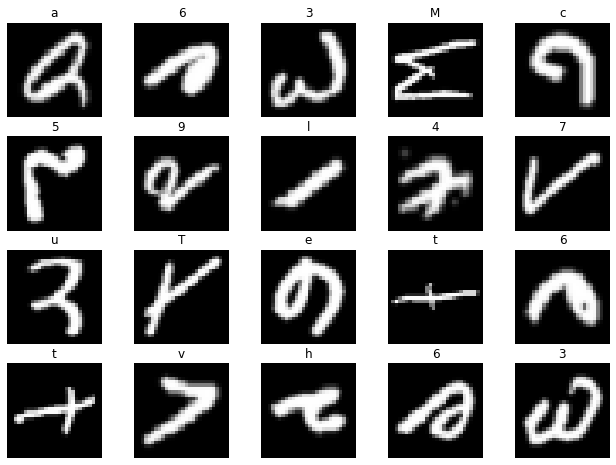

In [ ]:
show_data_scheme(train_data, train_label)

## 여기부터 다음 #까지는 전체 data train에 활용할 때만 돌릴 것

In [ ]:
f_train_data = tf.image.grayscale_to_rgb(train_data)
f_val_data = tf.image.grayscale_to_rgb(val_data)
# f_test_data = tf.image.grayscale_to_rgb(t_test_data)
# t_test_data = []

In [ ]:
boundary = int(train_data.shape[0]*0.8)

final_train = f_train_data[:boundary]
final_train_label = train_label[:boundary]

final_val = f_train_data[boundary:]
final_val_label = train_label[:boundary]

## 여기까지

In [22]:
final_train = tf.image.grayscale_to_rgb(train_data)
final_val = tf.image.grayscale_to_rgb(val_data)

## 여기는 balanced 일때만

In [23]:
final_train[0].shape

TensorShape([28, 28, 3])

In [24]:
mean = np.mean(train_data)
std = np.std(train_data)

In [25]:
print(mean)
print(std)

44.412914
84.77896


In [26]:
mobile2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (224, 224, 3), include_top=False)

In [ ]:
mobile2.summary()

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(62, activation = 'softmax')

test_model = keras.models.Sequential()
test_model.add(tf.keras.layers.Normalization( axis=-1, mean=44.412914, variance=84.77896, input_shape = (28, 28, 3)))
test_model.add(tf.keras.layers.Resizing(height = 224, width = 224))
test_model.add(mobile2)
test_model.add(global_average_layer)
test_model.add(tf.keras.layers.Dense(1000))
test_model.add(tf.keras.layers.ReLU())
test_model.add(prediction_layer)

In [ ]:
test_model.summary()

In [30]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(
            f'''
            epcoh : {epoch}
            loss {logs['loss']}
            accuracy {logs['accuracy']}
            val_loss {logs['val_loss']}
            val_accuracy {logs['val_accuracy']}
            '''
        )


In [31]:
test_model.compile(loss="sparse_categorical_crossentropy",
                optimizer="Adam",
                steps_per_execution=1200,
                metrics=["accuracy"])

In [ ]:
#  with tf.device("/cpu:0"):
a = test_model.fit(final_train[:400], train_label[:400], 
                  epochs=10, validation_data=(final_val[:80], val_label[:80]), callbacks=[LossAndErrorPrintingCallback()])

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 3.0696e-08 - accuracy: 1.0000
            epcoh : 0
            loss 3.0696369890392816e-08
            accuracy 1.0
            val_loss 0.0
            val_accuracy 1.0
            
13/13 [==============================] - 13s 1s/step - loss: 3.0696e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.8477e-08 - accuracy: 1.0000
            epcoh : 1
            loss 1.8477429364338605e-08
            accuracy 1.0
            val_loss 0.0
            val_accuracy 1.0
            
13/13 [==============================] - 3s 197ms/step - loss: 1.8477e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 6.5565e-09 - accuracy: 1.0000
            epcoh : 2
            loss 6.5565091134089926e-09
            accuracy 1.0
            val_loss 0.0
          

In [ ]:
print(a.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [32]:
def select_opt(opt_name, lr):
  if opt_name == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
  elif opt_name == 'sgd':
    optimizer = keras.optimizers.SGD(learning_rate = lr)
  elif opt_name == 'momentum':
    optimizer = keras.optimizers.SGD(learning_rate = lr, momentum=0.9)
  elif opt_name == 'nesterov':
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
  elif opt_name == 'adagrad':
    optimizer = keras.optimizers.Adagrad(learning_rate=lr)
  elif opt_name == 'adamax':
    optimizer = keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'nadam':
    optimizer = keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

  return optimizer

In [33]:
def select_activation(function):
  if function == 'relu':
    activation = keras.layers.ReLU()
  elif function == 'prelu':
    activation = keras.layers.PReLU()
  elif function == 'leacky_relu':
    activation = keras.layers.LeakyReLU()
  elif function == 'elu':
    activation = keras.layers.ELU()

  return activation

In [34]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f'''
              epcoh : {epoch}
              loss {logs['loss']}
              accuracy {logs['accuracy']}
              val_loss {logs['val_loss']}
              val_accuracy {logs['val_accuracy']}
              ''')
        wandb.log({'epochs': epoch,
            'loss': logs['loss'],
            'acc': logs['accuracy'], 
            'val_loss': logs['val_loss'],
            'val_acc': logs['val_accuracy']})
        

In [48]:
def sweep_train(config_defaults=None):
    # Set default values
    config_defaults = {
      'batch_size': 64,
      'optimizer' : 'adam',
      'learning_rate' : 0.01,
      'activation' : 'relu',
      'n_Dense_layer' : 1,
      'first_layer_node' : 1000,
      'second_layer_node' : 100
    }
    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    # initialize model
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(62, activation = 'softmax')
    node_per_layer = [wandb.config.first_layer_node, wandb.config.second_layer_node]
    

    model = keras.models.Sequential()
    model.add(tf.keras.layers.Normalization( axis=-1, mean=44.412914, variance=84.77896, input_shape = (28, 28, 3)))
    model.add(tf.keras.layers.Resizing(height = 224, width = 224))
    model.add(mobile2)
    model.add(global_average_layer)
    for i in range(wandb.config.n_Dense_layer):
      model.add(tf.keras.layers.Dense(node_per_layer[i]))
      model.add(select_activation(wandb.config.activation))
    model.add(prediction_layer)
    
    print(model.summary())

    # Instantiate an optimizer to train the model.
    optimizer = select_opt(wandb.config.optimizer, wandb.config.learning_rate)
    # Instantiate a loss function.
    # loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                steps_per_execution=1000,
                metrics=["accuracy"])
    hist = model.fit(final_train, train_label, epochs=20, validation_data=(final_val, val_label), callbacks=[LossAndErrorPrintingCallback()])

In [49]:
sweep_config = {
  'method': 'random', 
  'parameters': {
      
      'optimizer': {
          'values' : ['adam', 'rmsprop', 'sgd', 'momentum', 'nesterov', 'adagrad', 'adamax', 'nadam']
      },
      'learning_rate':{
          'values' : [0.1, 0.05, 0.01, 0.005]
      },
      'activation' : {
          'values' : ['relu', 'leacky_relu', 'elu']
      },
      'n_Dense_layer' : {
          'values' : [1, 2]
      },
      'first_layer_node' : {
          'values' : [1000, 800, 500]
      },
      'second_layer_node' : {
          'values' : [100, 120]
      }
  }
}

In [50]:
sweep_id = wandb.sweep(sweep_config, project="eeee")

Create sweep with ID: q41w5tai
Sweep URL: https://wandb.ai/chanin-eom/eeee/sweeps/q41w5tai


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=50)

wandb: Agent Starting Run: 8e72jcm4 with config:
wandb: 	activation: elu
wandb: 	first_layer_node: 800
wandb: 	learning_rate: 0.01
wandb: 	n_Dense_layer: 1
wandb: 	optimizer: adam
wandb: 	second_layer_node: 120
wandb: Currently logged in as: chanin-eom. Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 800)               1024800   
                                                        

acc,▁▆▇▇▇▇▇▇▇███████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▂▂▂▁▅▁▃▇▁▇▆██▁▃
val_loss,▄▄█▃▆▂▂▃▅▁▅▁▁▃▁▁▁▁▆▂
acc,0.75597
epochs,19
loss,0.57133
val_acc,0.24016
val_loss,7.90271


wandb: Agent Starting Run: st8ogbrm with config:
wandb: 	activation: relu
wandb: 	first_layer_node: 500
wandb: 	learning_rate: 0.1
wandb: 	n_Dense_layer: 1
wandb: 	optimizer: adamax
wandb: 	second_layer_node: 100


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 500)               640500    
                                                        

acc,▁▅▆▆▇▇▇▇▇▇▇▇████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▅▇█▆███▆▅▃▂▅▃█▂▇██
val_loss,█▂▂▁▁▁▁▁▁▁▂▂▃▂▂▁▂▁▁▁
acc,0.74618
epochs,19
loss,0.59089
val_acc,0.69379
val_loss,0.84982


wandb: Agent Starting Run: nfi7wvck with config:
wandb: 	activation: relu
wandb: 	first_layer_node: 800
wandb: 	learning_rate: 0.05
wandb: 	n_Dense_layer: 2
wandb: 	optimizer: adamax
wandb: 	second_layer_node: 100


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 800)               1024800   
                                                        

acc,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▆▁▃▅▇▇▆▆█▃▆█▅██▄▆█▇█
val_loss,▂█▅▂▁▁▁▂▁▅▂▂▃▂▁▄▄▂▃▂
acc,0.7926
epochs,19
loss,0.46213
val_acc,0.75129
val_loss,0.71544


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8qrsxd8a with config:
wandb: 	activation: elu
wandb: 	first_layer_node: 500
wandb: 	learning_rate: 0.01
wandb: 	n_Dense_layer: 1
wandb: 	optimizer: adam
wandb: 	second_layer_node: 120


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 500)               640500    
                                                        

acc,▁▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▁▇▇▆▇▅▇▇█▇▇█▇▇▇█▇▇█▆
val_loss,█▂▂▂▁▄▂▃▁▁▂▁▂▂▁▁▂▂▂▃
acc,0.79942
epochs,19
loss,0.45461
val_acc,0.69194
val_loss,0.83159


wandb: Agent Starting Run: 5lnb3lp8 with config:
wandb: 	activation: leacky_relu
wandb: 	first_layer_node: 1000
wandb: 	learning_rate: 0.05
wandb: 	n_Dense_layer: 2
wandb: 	optimizer: momentum
wandb: 	second_layer_node: 120


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1000)              1281000   
                                                        

acc,▁▆▇▇▇▇▇█████████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▆▅▇▅▇▇█▁█▇▇██▇▇███▇▇
val_loss,▃▄▂▅▁▂▂█▂▃▂▂▂▂▃▃▂▃▃▃
acc,0.8351
epochs,19
loss,0.3653
val_acc,0.75911
val_loss,0.61843


wandb: Agent Starting Run: 7eqzyfoa with config:
wandb: 	activation: relu
wandb: 	first_layer_node: 800
wandb: 	learning_rate: 0.05
wandb: 	n_Dense_layer: 1
wandb: 	optimizer: sgd
wandb: 	second_layer_node: 100


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 800)               1024800   
                                                        

acc,▁▆▇▇▇███████████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇▇▇▇████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.82369
epochs,19
loss,0.41275
val_acc,0.77968
val_loss,0.54009


wandb: Agent Starting Run: 7s1z0dce with config:
wandb: 	activation: relu
wandb: 	first_layer_node: 1000
wandb: 	learning_rate: 0.1
wandb: 	n_Dense_layer: 1
wandb: 	optimizer: momentum
wandb: 	second_layer_node: 120


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1000)              1281000   
                                                        

acc,▁▅▆▆▆▇▇▇▇▇▇▇▇███████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▆▆▂▁▄▇▇█▇▇▇█▅▇▇▇▅▇▇
val_loss,▃▁▁▇█▅▂▂▁▂▃▂▃▇▂▃▄▅▄▄
acc,0.8465
epochs,19
loss,0.34379
val_acc,0.77145
val_loss,0.6213


wandb: Agent Starting Run: kpbxyd47 with config:
wandb: 	activation: elu
wandb: 	first_layer_node: 500
wandb: 	learning_rate: 0.01
wandb: 	n_Dense_layer: 2
wandb: 	optimizer: nadam
wandb: 	second_layer_node: 120


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28, 28, 3)        0         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 500)               640500    
                                                        